## Setup

In [2]:
# import packages
import xarray as xr
import geopandas as gpd
# from rasterio.features import geometry_mask
# from rasterstats import zonal_stats
import numpy as np
import regionmask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
# Define netCDF file location
ds_location = r"C:\Users\Kris\Documents\amazonforcast\data\2023\202301\LIS_HIST_2023_Jan.nc"
# Define shape file location
shp_location = r"C:\Users\Kris\Documents\amazonforcast\gisfiles\hydrobasins shape\hybas_sa_lev05_areaofstudy.shp"

# netcdf file loader
ds = xr.open_dataset(ds_location)
# .shp file loader
hybas_sa_lev05 = gpd.read_file(shp_location)


In [4]:
# Reproject current crs of gdf to epsg 4326
print(f"East-West range: {ds.east_west.min().item()} to {ds.east_west.max().item()}")
print(f"North-South range: {ds.north_south.min().item()} to {ds.north_south.max().item()}")

print(hybas_sa_lev05.total_bounds)  # This will print the bounds of the regions in your GeoDataFrame

# Print current CRS of the GeoDataFrame
print(f"Original CRS: {hybas_sa_lev05.crs}")

# Reproject to WGS84 (latitude and longitude)
hybas_sa_lev05 = hybas_sa_lev05.to_crs(epsg=4326)

# Print new CRS to confirm
print(f"Reprojected CRS: {hybas_sa_lev05.crs}")

# Check the bounds again after reprojection
print(hybas_sa_lev05.total_bounds)

East-West range: -82.0 to -49.0
North-South range: -21.0 to 6.0
[-9054007.67266785 -2376978.16229946 -5440740.11254905   671070.13011205]
Original CRS: EPSG:3857
Reprojected CRS: EPSG:4326
[-81.33353475 -20.87498542 -48.875        6.01723395]


In [5]:
# Convert data types if necessary
#ds['east_west'] = ds.east_west.astype(np.float64)
#ds['north_south'] = ds.north_south.astype(np.float64)

# Create meshgrid for coordinates
# lon, lat = np.meshgrid(ds.east_west.values, ds.north_south.values)

# Flatten the meshgrid for plotting
# lon_flat = lon.flatten()
# lat_flat = lat.flatten()

# Debugging step: Check coordinate values
# print("Longitude range:", lon_flat.min(), "to", lon_flat.max())
# print("Latitude range:", lat_flat.min(), "to", lat_flat.max())

Longitude range: -82.0 to -49.0
Latitude range: -21.0 to 6.0


In [6]:
# Check dimensions
# print(f"East-West shape: {ds.east_west.shape}")
# print(f"North-South shape: {ds.north_south.shape}")
print(f"Dataset spatial shape: ({ds.sizes['north_south']}, {ds.sizes['east_west']})")

# Create a list for the variable names
# list_of_variables = ['Rainf_tavg','SoilMoist_inst','Qs_tavg','Evap_tavg','SoilTemp_inst','Qair_f_tavg'] 
# rainf_tavg = ds['Rainf_tavg']
# ds['Rainf_tavg'].plot()
# rainf_tavg


Dataset spatial shape: (540, 660)


In [7]:
aoi = hybas_sa_lev05[hybas_sa_lev05.PFAF_ID == 62297]

# Get lat min, max
# aoi_lat = [float(aoi.total_bounds[1]), float(aoi.total_bounds[3])]
#aoi_lon = [float(aoi.total_bounds[0]), float(aoi.total_bounds[2])]
# Notice that the longitude values have negative numbers
# we need these values in a global crs so we can subtract from 360
# aoi_lat, aoi_lon
type(aoi)

geopandas.geodataframe.GeoDataFrame

In [8]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region
aoi_mask = regionmask.mask_3D_geopandas(aoi,
                                         ds.east_west,
                                         ds.north_south)
aoi_mask

<xarray.DataArray 'mask' (region: 1, north_south: 540, east_west: 660)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * north_south  (north_south) float64 -21.0 -20.95 -20.9 ... 5.9 5.95 6.0
  * east_west    (east_west) float64 -82.0 -81.95 -81.9 ... -49.1 -49.05 -49.0
  * region       (region) int64 90
Attributes:
    standard_name:  region

In [9]:
aoi_ds = ds.where(aoi_mask)
aoi_ds

<xarray.Dataset>
Dimensions:           (time: 31, north_south: 540, east_west: 660, region: 1,
                       SoilMoist_profiles: 4, SoilTemp_profiles: 4)
Coordinates:
  * time              (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-31
  * north_south       (north_south) float64 -21.0 -20.95 -20.9 ... 5.9 5.95 6.0
  * east_west         (east_west) float64 -82.0 -81.95 -81.9 ... -49.05 -49.0
  * region            (region) int64 90
Dimensions without coordinates: SoilMoist_profiles, SoilTemp_profiles
Data variables: (12/32)
    lat               (time, north_south, east_west, region) float32 nan ... nan
    lon               (time, north_south, east_west, region) float32 nan ... nan
    Swnet_tavg        (time, north_south, east_west, region) float32 nan ... nan
    Lwnet_tavg        (time, north_south, east_west, region) float32 nan ... nan
    Qle_tavg          (time, north_south, east_west, region) float32 nan ... nan
    Qh_tavg           (time, north_south, east_west, region) float32 nan ... nan
    ...                ...
    Qair_f_tavg       (time, north_south, east_west, region) float32 nan ... nan
    Psurf_f_tavg      (time, north_south, east_west, region) float32 nan ... nan
    SWdown_f_tavg     (time, north_south, east_west, region) float32 nan ... nan
    LWdown_f_tavg     (time, north_south, east_west, region) float32 nan ... nan
    LAI_inst          (time, north_south, east_west, region) float32 nan ... nan
    Greenness_inst    (time, north_south, east_west, region) float32 nan ... nan
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNESSES:  [ 10.        30.000002  60.000004 100.      ]
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  
    ...                      ...
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   -20.975
    SOUTH_WEST_CORNER_LON:   -81.975
    DX:                      0.05
    DY:                      0.05

### Checking by plotting using matploitlib


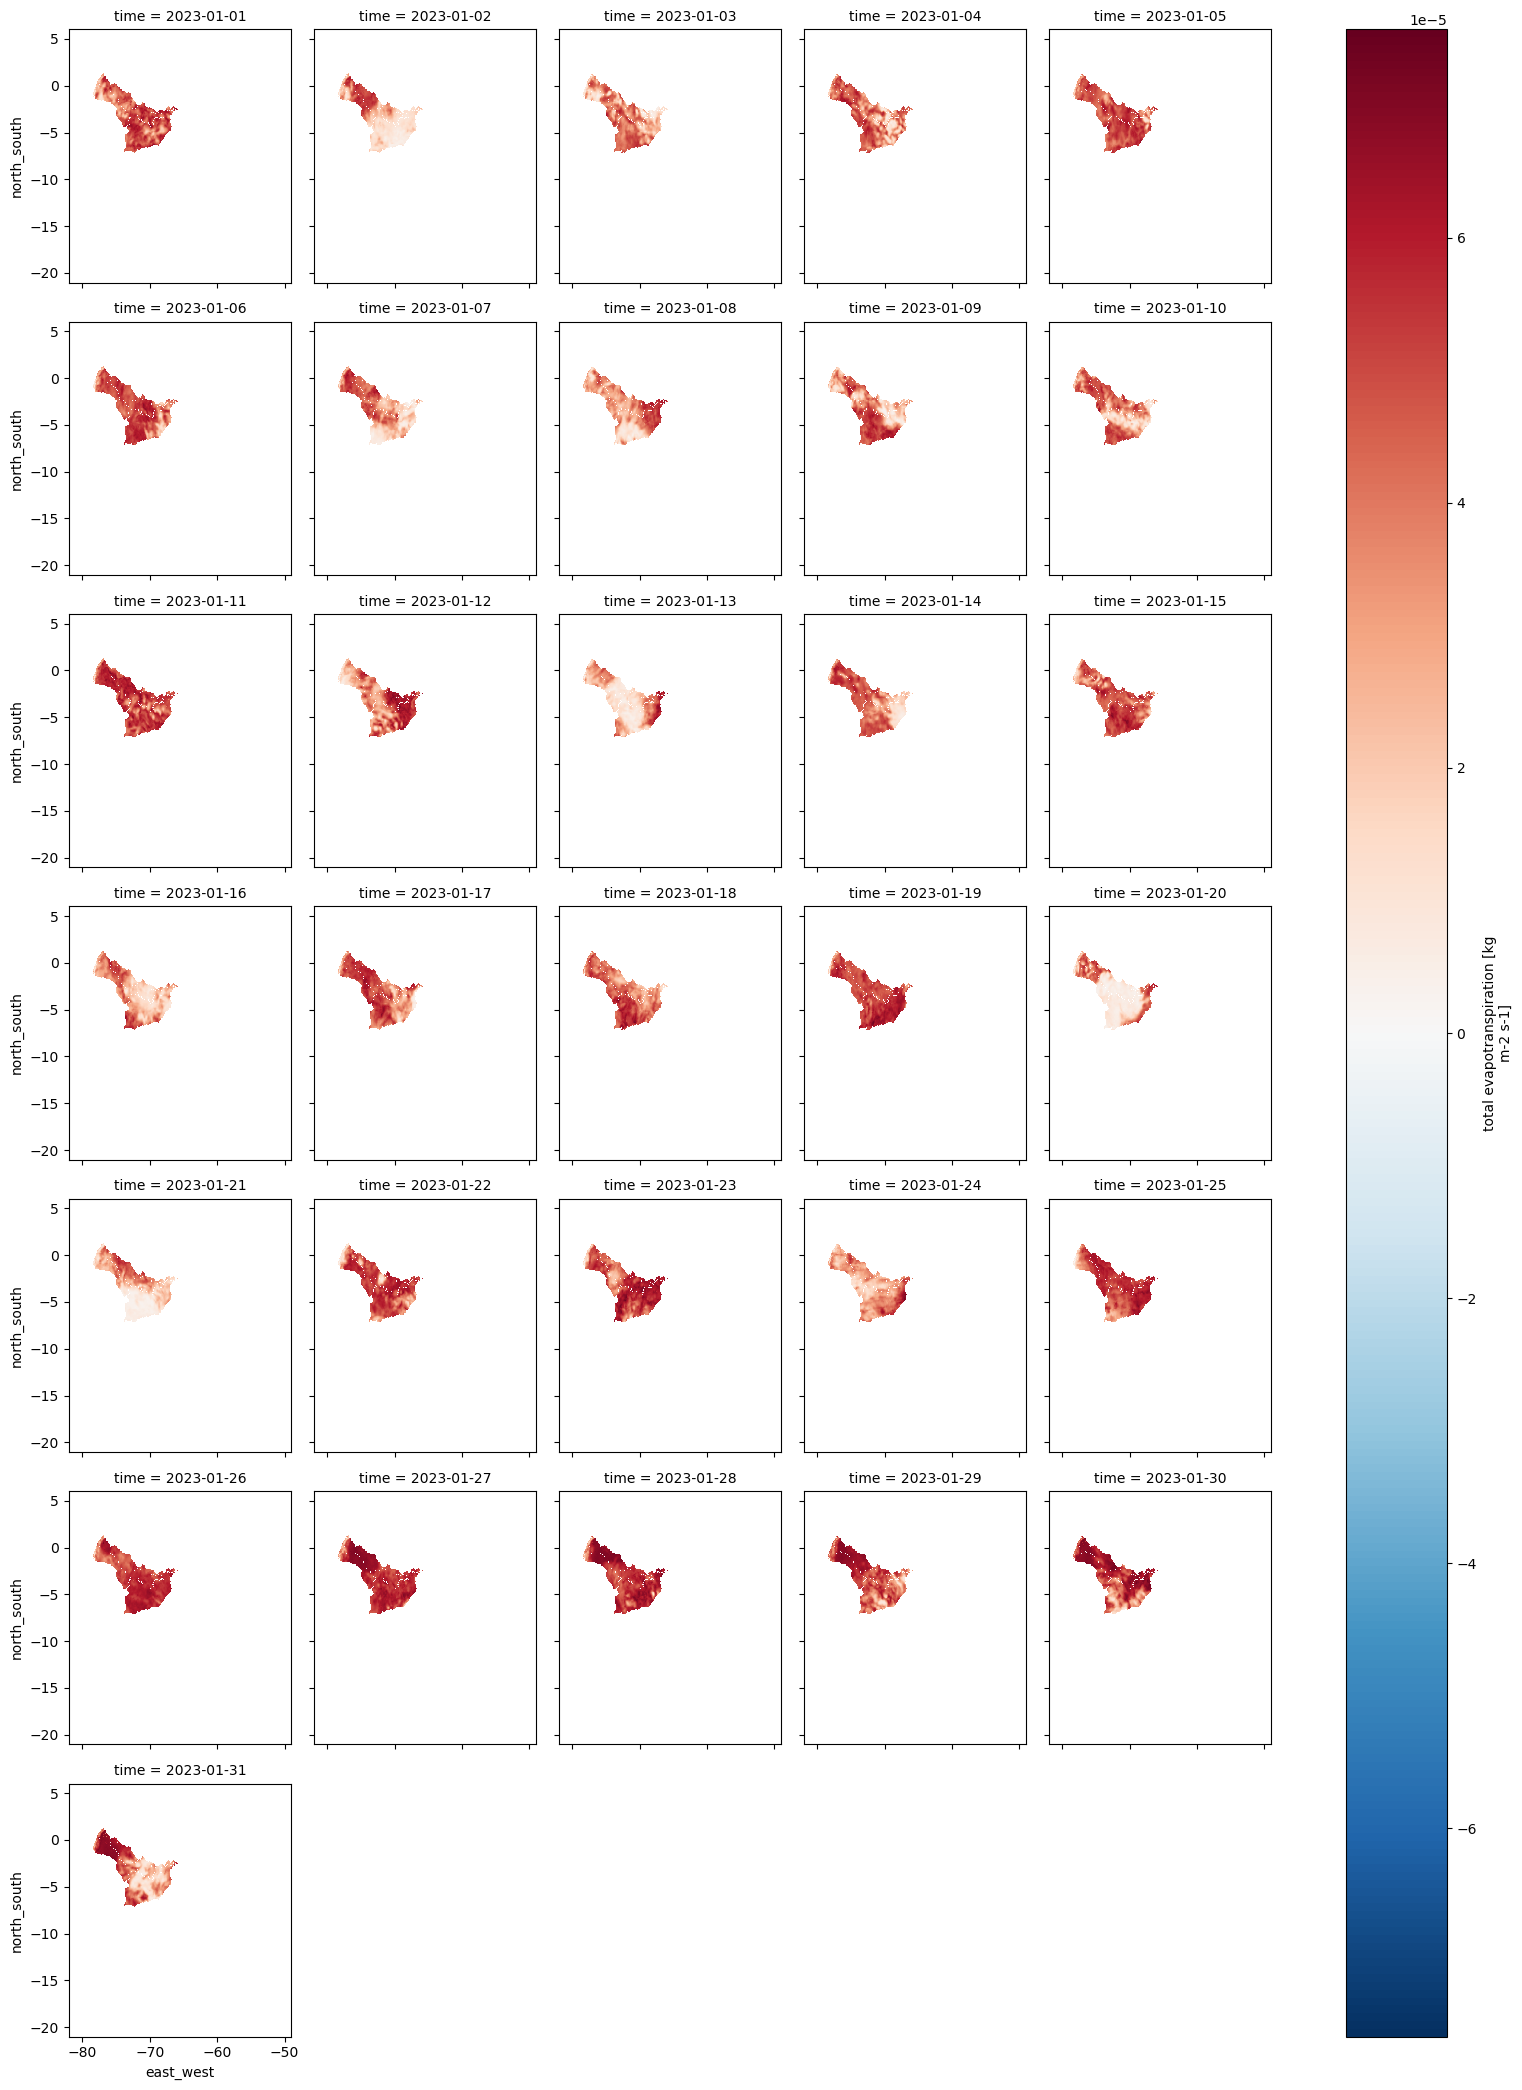

In [13]:
aoi_ds['Evap_tavg'].plot(col = 'time', col_wrap = 5)
plt.show()

### Checking by plotting using plotly


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Extract the 'Rainf_tavg' variable
aoi_rainf = aoi_ds['Rainf_tavg']

# Convert to pandas DataFrame
# aoi_rainf_df = aoi_rainf.to_dataframe().reset_index()

# Create a subplot grid
# Define the number of rows and columns for subplots
fig = make_subplots(rows = 7, cols = 5, subplot_titles=[f"time = {str(date)[:10]}" for date in aoi_rainf['time'].values])

# Add each day's data as a trace
for i, date in enumerate(aoi_rainf['time'].values):
    # Extract data for the specific date
    day_data = aoi_rainf.sel(time=date).to_dataframe().reset_index()
    
    # Create a scatter plot for the day's data
    trace = go.Heatmap(
        x=day_data['east_west'],
        y=day_data['north_south'],
        z=day_data['Rainf_tavg'],
        coloraxis="coloraxis"
    )
    
    # Determine subplot position
    row = i // cols + 1
    col = i % cols + 1
    
    # Add trace to the subplot
    fig.add_trace(trace, row=row, col=col)

# Update layout
fig.update_layout(
    height=2000, 
    coloraxis={'colorscale':'RdBu_r'},
    showlegend=False
)

# Show the plot
fig.show()


### Zonal Stats to dataframe

In [28]:
summary = aoi_ds['Rainf_tavg'].groupby("time").mean(["north_south", "east_west"])
aoi_ds_summary = summary.to_dataframe()
aoi_ds_summary

,,Rainf_tavg
time,region,
2023-01-01,90,0.000093
2023-01-02,90,0.000163
2023-01-03,90,0.000051
2023-01-04,90,0.000027
2023-01-05,90,0.000024
2023-01-06,90,0.000107
2023-01-07,90,0.000179
2023-01-08,90,0.000139
2023-01-09,90,0.000152
